# 🧹 Préparation du Dataset BTC Tweets 📊

Ce notebook prépare le jeu de données **BTC_Tweets_Sentiments.csv**, contenant des tweets annotés manuellement selon leur **polarité** (positive ou négative). Il est utilisé pour entraîner un modèle de classification des sentiments en lien avec le Bitcoin. 🪙

## Objectifs 🎯
- Nettoyer les tweets (ponctuation, mentions, hashtags...)
- Visualiser la distribution des sentiments
- Préparer un jeu d'entraînement équilibré et robuste
- Créer des jeux d'entraînement, validation et test
- Déduire des hyperparamètres pertinents pour l'entrainement à partir des données
- Sauvegarder les datasets dans le dossier `data/`


## 🔍 Importation des librairies et Chargement du Dataset

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

In [2]:
# Nettoyage des anciens fichiers
for split in ["train.csv", "val.csv", "test.csv"]:
    path = f"../dataset/{split}"
    if os.path.exists(path):
        os.remove(path)
        print(f"🗑️ Supprimé : {path}")

In [3]:
# Chargement du dataset
try:
    df = pd.read_csv("../data/BTC_Tweets_Sentiments.csv")
    df.head(10)
except FileNotFoundError:
    print("Erreur : le fichier spécifié est introuvable.")
except pd.errors.EmptyDataError:
    print("Erreur : le fichier est vide.")
except pd.errors.ParserError:
    print("Erreur : échec de l'analyse du fichier.")
except Exception as e:
    print(f"Une erreur inattendue est survenue : {e}")

## 🏷️ Nettoyage et encodage des sentiments

Dans cette étape, nous nettoyons la colonne `Sentiment` pour supprimer les caractères inutiles (`[`, `]`, `'`) qui peuvent provenir d’une mauvaise importation ou annotation.

Ensuite, nous ne conservons que les tweets **positifs** et **négatifs**, en excluant les neutres ou mal étiquetés.  
Enfin, nous encodons les labels pour la classification binaire :
- `0` pour **négatif**
- `1` pour **positif**

🧼 Ce prétraitement est indispensable pour préparer les données à l'entraînement d’un modèle de classification supervisée.

In [4]:
df['Sentiment'] = df['Sentiment'].str.replace(r"[\[\]']", "", regex=True).str.strip()
df = df[df['Sentiment'].isin(['positive', 'negative'])].reset_index(drop=True)
df['label'] = df['Sentiment'].map({'negative': 0, 'positive': 1})
df.head()

,id,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,New_Sentiment_Score,New_Sentiment_State,BERT Labels,label
0,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",positive,1.0,0.136364,1.0,0,1
1,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",positive,1.0,0.400000,1.0,0,1
2,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",positive,1.0,0.468182,1.0,0,1
3,5,Fri Mar 23 00:40:36 +0000 2018,Copy successful traders automatically with Bit...,VictorS61164810,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",positive,1.0,0.750000,1.0,1,1
4,6,Fri Mar 23 00:40:37 +0000 2018,RT @bethereumteam: We're revealing our surpris...,ClarkKalel4,"[u'surprise', u'presents', u'crypto', u'bitcoin']","<a href=""http://twitter.com/download/android"" ...",positive,1.0,0.200000,1.0,0,1


## 🧹 Nettoyage du texte des tweets

Avant d’analyser les tweets, il est crucial de les nettoyer pour enlever le bruit et les éléments inutiles à la compréhension du modèle.  
Voici les opérations effectuées :

- Suppression des liens (`http...`)
- Suppression des mentions Twitter (`@username`)
- Suppression du caractère `#` des hashtags
- Suppression de toute ponctuation ou caractère spécial
- Suppression du tag `rt`
- Suppression des espaces inutiles
- Conversion en minuscules pour uniformiser

🔤 Cela permet d'obtenir un texte plus propre et cohérent, stocké dans une nouvelle colonne `clean_text`, que nous utiliserons pour l'entraînement du modèle.

In [5]:
def clean_text(text):
    text = re.sub(r"http\S+|@\S+|#[A-Za-z0-9_]+", "", text)  # Remove URLs, mentions, hashtags
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)               # Remove non-alphanumerics
    text = re.sub(r"\brt\b", "", text, flags=re.IGNORECASE)  # Remove "rt" as standalone word
    text = text.replace("amp", "")                           # Remove HTML artifact
    text = re.sub(r"\s+", " ", text)                         # Normalize whitespace
    return text.lower().strip()

df["clean_text"] = df["Tweet"].apply(clean_text)
df.head()

,id,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,New_Sentiment_Score,New_Sentiment_State,BERT Labels,label,clean_text
0,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",positive,1.0,0.136364,1.0,0,1,another use case for and the can unseat facebo...
1,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",positive,1.0,0.400000,1.0,0,1,free coins
2,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",positive,1.0,0.468182,1.0,0,1,we are happy to announce that payvx presale ph...
3,5,Fri Mar 23 00:40:36 +0000 2018,Copy successful traders automatically with Bit...,VictorS61164810,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",positive,1.0,0.750000,1.0,1,1,copy successful traders automatically with bit...
4,6,Fri Mar 23 00:40:37 +0000 2018,RT @bethereumteam: We're revealing our surpris...,ClarkKalel4,"[u'surprise', u'presents', u'crypto', u'bitcoin']","<a href=""http://twitter.com/download/android"" ...",positive,1.0,0.200000,1.0,0,1,were revealing our surprise tomorrow are you r...


## 🧹 Suppression des doublons (retweet...) et des textes vides

In [6]:
before = len(df)
df = df[~df["clean_text"].isna()]  # supprime les NaN
df = df[df["clean_text"].str.strip() != ""]  # supprime les chaînes vides ou avec seulement des espaces
df = df.reset_index(drop=True)
after = len(df)
print(f"🧹 Removed {before - after} empty or whitespace-only entries.")

🧹 Removed 1 empty or whitespace-only entries.


In [7]:
before = len(df)
df = df.drop_duplicates(subset=["clean_text"]).reset_index(drop=True)
after = len(df)
print(f"🧹 Removed {before - after} duplicate entries.")

🧹 Removed 19152 duplicate entries.


## 📊 Analyse Exploratoire (EDA)

Après avoir nettoyé les textes, explorons notre jeu de données pour mieux comprendre sa structure et identifier d'éventuels biais.

### 🔢 Répartition des classes

Nous vérifions la distribution des tweets positifs et négatifs afin de repérer un éventuel déséquilibre.  
Un déséquilibre fort pourrait nécessiter un rééchantillonnage (oversampling/undersampling).


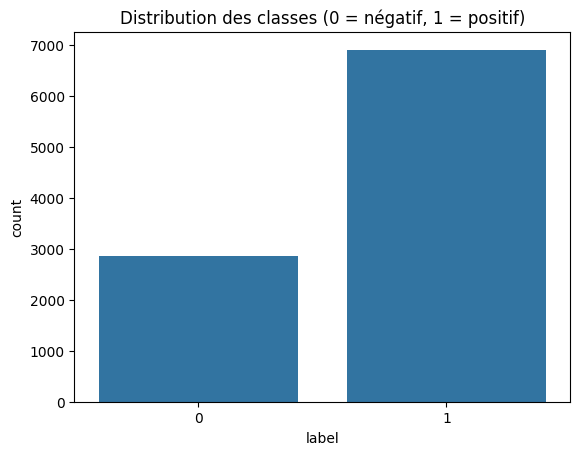

In [8]:
# Répartition des classes
sns.countplot(data=df, x="label")
plt.title("Distribution des classes (0 = négatif, 1 = positif)")
plt.show()

### 📏 Distribution des longueurs de texte

Les modèles comme BERT ont une longueur maximale d’entrée.  
Analyser la longueur des tweets permet de décider s’il faut tronquer ou ajuster la tokenisation.


📏 Statistiques sur la longueur des tweets (en mots) :
   ➕ Moyenne       : 13.9 mots
   🟰 Médiane       : 14 mots
   🔽 Minimum       : 1 mots
   🔼 Maximum       : 35 mots
   🧮 75e percentile: 17 mots


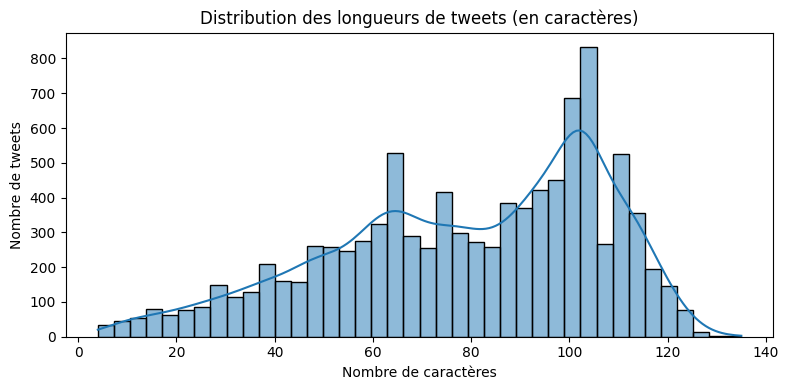

In [9]:
# 📊 Statistiques descriptives sur la longueur des textes (en mots)
df["text_length_words"] = df["clean_text"].apply(lambda x: len(x.split()))

print("\n📏 Statistiques sur la longueur des tweets (en mots) :")
print(f"   ➕ Moyenne       : {df['text_length_words'].mean():.1f} mots")
print(f"   🟰 Médiane       : {df['text_length_words'].median():.0f} mots")
print(f"   🔽 Minimum       : {df['text_length_words'].min()} mots")
print(f"   🔼 Maximum       : {df['text_length_words'].max()} mots")
print(f"   🧮 75e percentile: {np.percentile(df['text_length_words'], 75):.0f} mots")

# 📉 Distribution de la longueur des textes (en caractères)
df["text_length"] = df["clean_text"].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(df["text_length"], bins=40, kde=True)
plt.title("Distribution des longueurs de tweets (en caractères)")
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre de tweets")
plt.tight_layout()
plt.show()


📏 Statistiques sur la longueur des tweets (en mots) :
   ➕ Moyenne       : 13.9 mots
   🟰 Médiane       : 14 mots
   🔽 Minimum       : 1 mots
   🔼 Maximum       : 35 mots
   🧮 75e percentile: 17 mots


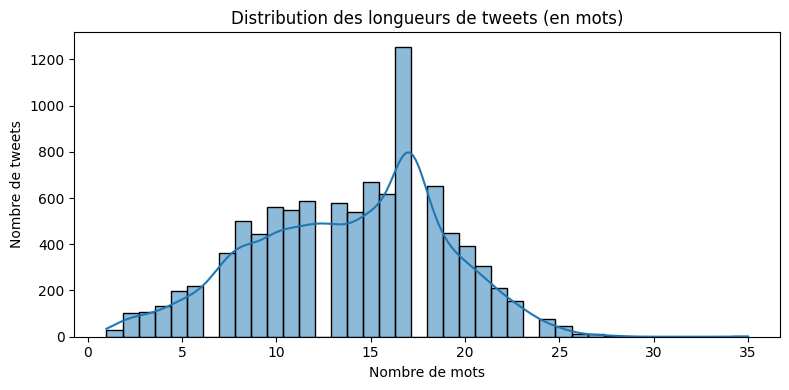

In [10]:
# 📊 Statistiques descriptives sur la longueur des textes (en mots)
df["text_length_words"] = df["clean_text"].apply(lambda x: len(x.split()))

print("\n📏 Statistiques sur la longueur des tweets (en mots) :")
print(f"   ➕ Moyenne       : {df['text_length_words'].mean():.1f} mots")
print(f"   🟰 Médiane       : {df['text_length_words'].median():.0f} mots")
print(f"   🔽 Minimum       : {df['text_length_words'].min()} mots")
print(f"   🔼 Maximum       : {df['text_length_words'].max()} mots")
print(f"   🧮 75e percentile: {np.percentile(df['text_length_words'], 75):.0f} mots")

# 📉 Distribution de la longueur des textes (en mots)
plt.figure(figsize=(8, 4))
sns.histplot(df["text_length_words"], bins=40, kde=True)
plt.title("Distribution des longueurs de tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de tweets")
plt.tight_layout()
plt.show()

### 📈 Nuage de mots (`WordCloud`)

Visualisation des mots les plus fréquents dans chaque classe (positif et négatif).  
Cela permet d'identifier rapidement les tendances lexicales ou les biais de langage.

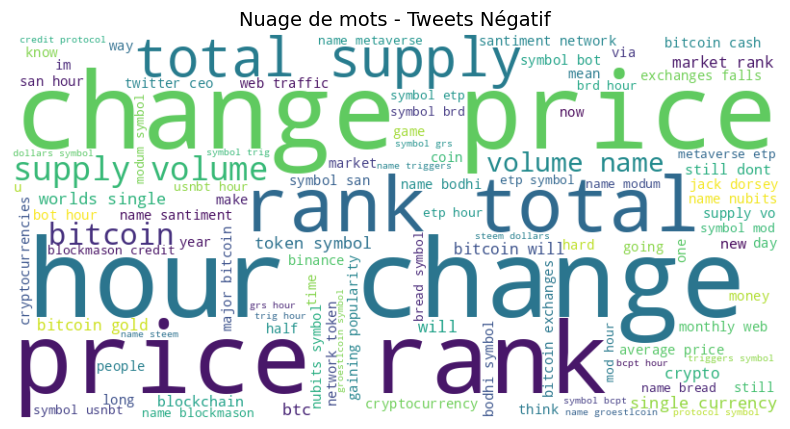

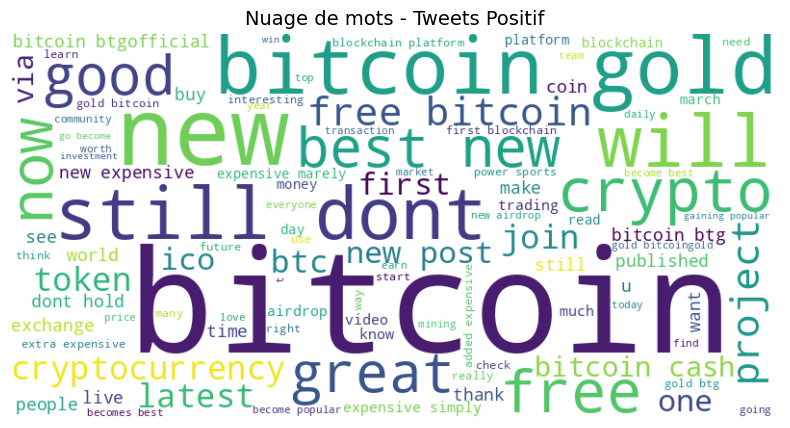

In [11]:
# Génération des nuages de mots
for label_value, label_name in zip([0, 1], ['Négatif', 'Positif']):
    text = " ".join(df[df['label'] == label_value]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuage de mots - Tweets {label_name}", fontsize=14)
    plt.show()

### 🧮 Mots les plus fréquents (`CountVectorizer`)

Analyse quantitative des mots les plus présents dans le corpus, utile pour comparer les différences lexicales entre les classes.

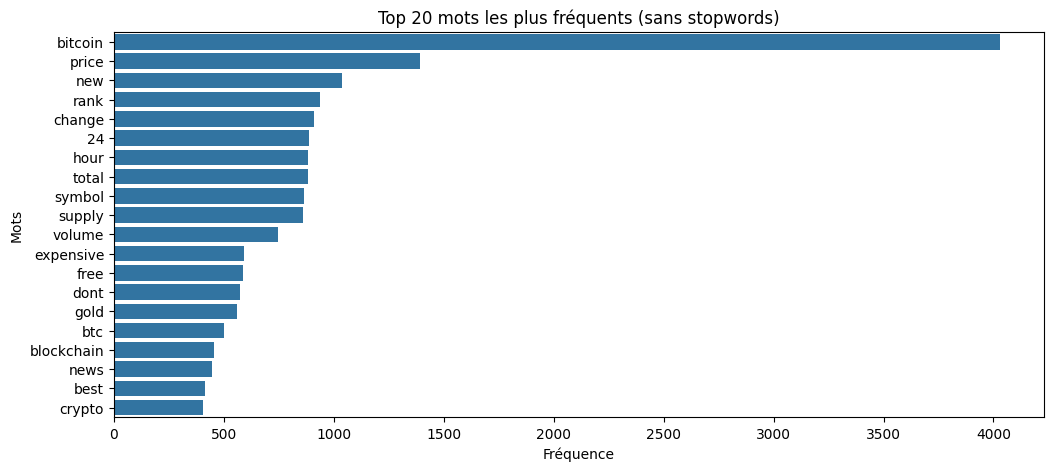

In [12]:
# Exclure les stopwords
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df["clean_text"])

# Récupération des fréquences
word_counts = X.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()
word_freq = dict(zip(vocab, word_counts))

# Top 20 mots les plus fréquents
common_words = Counter(word_freq).most_common(20)
words, freqs = zip(*common_words)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 mots les plus fréquents (sans stopwords)")
plt.xlabel("Fréquence")
plt.ylabel("Mots")
plt.show()

### 📊 Boxplot des longueurs de tweet par classe

Permet de visualiser si les tweets positifs sont en moyenne plus longs que les négatifs, ou vice versa.

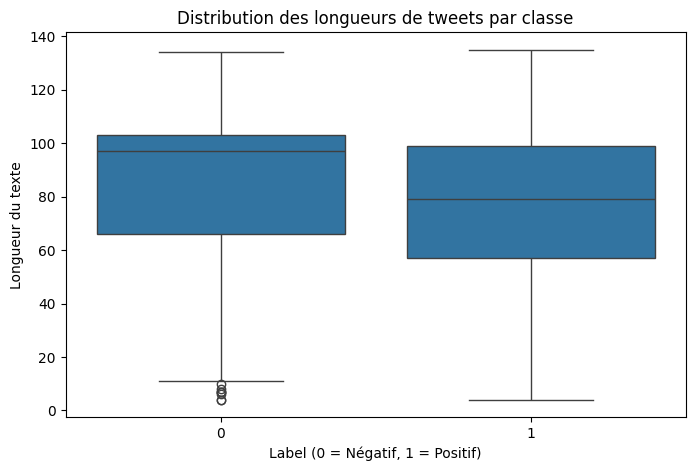

In [13]:
# longueurs de tweets par classe
df["text_length"] = df["clean_text"].apply(len)

plt.figure(figsize=(8, 5))
sns.boxplot(x="label", y="text_length", data=df)
plt.title("Distribution des longueurs de tweets par classe")
plt.xlabel("Label (0 = Négatif, 1 = Positif)")
plt.ylabel("Longueur du texte")
plt.show()

## ⚖️ Équilibrage des classes

Pour garantir que le modèle ne développe pas de biais en faveur de la classe majoritaire, nous équilibrons le dataset.  
🎯 L’objectif est d’avoir une répartition **équitable entre tweets positifs et négatifs** (50/50), ce qui est essentiel pour un apprentissage fiable en classification binaire.

In [14]:
min_count = df['label'].value_counts().min()
df_balanced = pd.concat([
    df[df['label'] == 0].sample(min_count, random_state=42),
    df[df['label'] == 1].sample(min_count, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

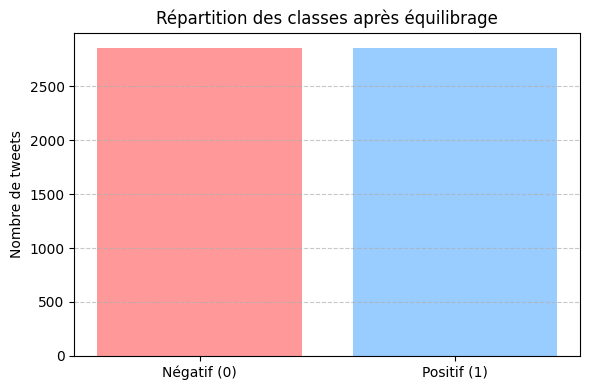

In [15]:
# Visualisation de la répartition après équilibrage
counts = df_balanced['label'].value_counts().sort_index()
labels = ['Négatif (0)', 'Positif (1)']
colors = ['#ff9999','#99ccff']
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=colors)
plt.title('Répartition des classes après équilibrage')
plt.ylabel('Nombre de tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 🧾 Réindexation & colonnes utiles

On réinitialise les index, attribue un identifiant unique (id), puis on ne conserve que les colonnes essentielles : `id`, `Tweet`, `clean_text` et `label`.

In [16]:
# Réindexation propre : suppression de l'ancien id si présent
if 'id' in df_balanced.columns:
    df_balanced.drop(columns=['id'], inplace=True)

# Réinitialiser les index et ajouter un ID de 1 à N
df_balanced = df_balanced.reset_index(drop=True)
df_balanced.insert(0, 'id', range(1, len(df_balanced) + 1))

# Ne conserver que les colonnes utiles et renommer Tweet en full_text
df_balanced = df_balanced[['id', 'Tweet', 'clean_text', 'label']]
df_balanced = df_balanced.rename(columns={"Tweet": "full_text"})
df_balanced.head(10)

,id,full_text,clean_text,label
0,1,Name: Modum\nSymbol: MOD\n24 hour change: -14....,name modum symbol mod 24 hour change 1414 pric...,0
1,2,#Investing 70.2% in this optimal #crypto portf...,702 in this optimal portfolio and 298 in the p...,0
2,3,RT @Disco_Snoopy: Jared Kushner Claims a ‘Gucc...,jared kushner claims a guccifer imposter deman...,0
3,4,#bitcoin Morning Brief with Tone Vays - Ledger...,morning brief with tone vays ledger snapchat o...,1
4,5,Cool. A thing that I need and don’t need the m...,cool a thing that i need and dont need the mos...,1
5,6,How important is #personal #data for a #busine...,how important is for a and visit us here,1
6,7,@ElixiumCrypto Bitcoin BTG(OFFICIAL) (Bitcoin-...,bitcoin btgofficial bitcoingold a become best ...,1
7,8,RT @GymRewards: Ready for #GYMBase? https://t....,ready for part of gym rewards solution with a for,1
8,9,Name: Matchpool\nSymbol: GUP\n24 hour change: ...,name matchpool symbol gup 24 hour change 644 p...,0
9,10,Name: Bodhi\nSymbol: BOT\n24 hour change: -5.8...,name bodhi symbol bot 24 hour change 582 price...,0


## 📏 Estimation de `max_length` pour la tokenisation sur le dataset final

Avant de fine-tuner un modèle de type BERT ou BERTweet, il est essentiel d'estimer une longueur maximale (`max_length`) adaptée pour la tokenisation.

- Si la longueur est trop courte, on perd de l'information (troncature).
- Si elle est trop longue, on gaspille de la mémoire GPU/CPU inutilement.

In [17]:
# Liste des modèles à comparer
models = {
    "vinai/bertweet-base": "BERTweet",
    "distilbert-base-uncased": "DistilBERT"
}

token_lengths = {}

for model_name, label in models.items():
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    lengths = df_balanced["clean_text"].apply(lambda x: len(tokenizer.tokenize(x)))
    p95 = np.percentile(lengths, 95)
    p99 = np.percentile(lengths, 99)
    token_lengths[label] = int(p99)

    print(f"📊 {label}")
    print(f"   🔹 95e percentile : {int(p95)} tokens")
    print(f"   🔹 99e percentile : {int(p99)} tokens\n")

# Choix du max_length optimal
max_length = max(token_lengths.values())

# Arrondi à la puissance de 2 supérieure
def next_power_of_2(x):
    return 2 ** int(np.ceil(np.log2(x)))

max_length_rounded = next_power_of_2(max_length)

print(f"✅ max_length retenu : {max_length_rounded} tokens (puissance de 2 la plus proche ≥ {max_length})")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


📊 BERTweet
   🔹 95e percentile : 27 tokens
   🔹 99e percentile : 29 tokens

📊 DistilBERT
   🔹 95e percentile : 30 tokens
   🔹 99e percentile : 33 tokens

✅ max_length retenu : 64 tokens (puissance de 2 la plus proche ≥ 33)


## 📁 Découpage en jeux d'entraînement/validation/test

In [18]:
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

Train: (3997, 4)
Validation: (856, 4)
Test: (857, 4)


## 💾 Sauvegarde des Datasets

In [19]:
os.makedirs("./data", exist_ok=True)

train_df.to_csv("./data/train.csv", index=False)
val_df.to_csv("./data/val.csv", index=False)
test_df.to_csv("./data/test.csv", index=False)

print("Fichiers exportés dans le dossier data/")

Fichiers exportés dans le dossier data/


## 📊 Conclusion: Estimation des hyperparamètres

| Hyperparamètre      | Description                                              | Comment l’EDA aide à le définir                                                                                                                             | Recommandation                        |
| ------------------- | -------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------- |
| **`max_length`**    | Longueur maximale des séquences (en tokens)              | 🔍 *EDA → Distribution des longueurs de textes (en tokens)* : permet de fixer une limite pour éviter le padding excessif          | 32 tokens                              |
| **`batch_size`**    | Nombre d’exemples par lot (batch)                        | 🧮 *EDA → Taille moyenne des textes* : plus les séquences sont longues, plus on réduit `batch_size` pour éviter une surcharge mémoire (CPU/GPU)             | 32                                        |
| **`epochs`**        | Nombre d’itérations complètes sur l’ensemble des données | 📈 *EDA → Volume de données* : plus le dataset est grand, moins on a besoin de beaucoup d’epochs. On ajoutera `EarlyStopping` dans les callbacks de l'entrainement pour éviter l’overfitting.         | 5                                        |
| **`learning_rate`** | Taux de mise à jour des poids lors de l’optimisation     | ⚙️ *EDA indirect* : pas lié à une statistique brute, mais à la complexité des données (variabilité, bruit). Prendre la valeur typique pour les modèles BERT. | 2e-5                                  |
| **`tokenizer`**     | Type de tokeniseur à utiliser selon le modèle            | 📚 *EDA → Langue, style et longueur des textes* : pour du langage Twitter en anglais, BERTweet et DistilBERT sont recommandé            | BERTweet DistilBERT en fonction du modèle |
